## Introdução
Nosso grupo enfrentou algumas dificuldades na definição do projeto, equilibrando a busca por uma proposta relevante com o receio de estabelecer objetivos além de nossas capacidades. Após diversas discussões e ideias, decidimos desenvolver uma solução que compara dois textos e, por meio de análises semânticas e sintáticas, calcula a similaridade entre eles em forma de porcentagem. Dessa maneira, buscamos inferir se os textos foram ou não produzidos pelo mesmo autor. 
Após a definição da nossa ideia, iniciamos pesquisas sobre o plano de ação para lidar com o problema proposto. Primeiramente, percebemos que o pré-processamento é uma etapa extremamente relevante e que difere consideravelmente de outros casos de PLN. Isso ocorre porque um autor pode expressar seus maneirismos linguísticos e estilísticos de maneira sutil, o que torna características geralmente descartadas — como o início e o fim de sentenças, a pontuação e o uso de stopwords — potencialmente relevantes para a análise.

## Coleta de dados 
Considerando o problema abordado, optamos inicialmente por buscar textos de autores em comum, mas com temáticas distintas. Dessa forma, conseguimos testar a funcionalidade da nossa solução minimizando possíveis interferências decorrentes da similaridade temática entre os textos. Para isso, utilizamos o site Domínio Público, onde foi possível encontrar obras de diversos autores em língua portuguesa.
Selecionamos, nesta etapa, quatro textos: A Cartomante e Dom Casmurro, de Machado de Assis, e O Cortiço e O Mulato, de Aluísio Azevedo. Atualmente, estamos utilizando esses quatro textos para testes, mas nossa intenção é expandir consideravelmente o conjunto de dados ao longo do desenvolvimento.


In [8]:
import os

# Diretórios de origem e destino
origem = "data/caps"
destino = "data/caps_processados"
os.makedirs(destino, exist_ok=True)

for nome_arquivo in os.listdir(origem):
    caminho_origem = os.path.join(origem, nome_arquivo)
    caminho_destino = os.path.join(destino, os.path.splitext(nome_arquivo)[0] + ".txt")
    if os.path.isfile(caminho_origem):
        with open(caminho_origem, 'r', encoding='utf-8') as f_origem:
            conteudo = f_origem.read()
        with open(caminho_destino, 'w', encoding='utf-8') as f_destino:
            f_destino.write(conteudo)
        print(f"Arquivo salvo: {caminho_destino}")

Arquivo salvo: data/caps_processados\dom_casmurro_machado_cap_1.txt
Arquivo salvo: data/caps_processados\dom_casmurro_machado_cap_2.txt
Arquivo salvo: data/caps_processados\dom_casmurro_machado_cap_3.txt
Arquivo salvo: data/caps_processados\dom_casmurro_machado_cap_4.txt
Arquivo salvo: data/caps_processados\iracema_jose_de_alencar_cap_1.txt
Arquivo salvo: data/caps_processados\iracema_jose_de_alencar_cap_2.txt
Arquivo salvo: data/caps_processados\iracema_jose_de_alencar_cap_3.txt
Arquivo salvo: data/caps_processados\iracema_jose_de_alencar_cap_4.txt
Arquivo salvo: data/caps_processados\o_cortico_aluisio_azevedo_cap_3.txt
Arquivo salvo: data/caps_processados\o_cortico_aluisio_de_azevedo_cap_1.txt
Arquivo salvo: data/caps_processados\o_cortico_aluisio_de_azevedo_cap_2.txt
Arquivo salvo: data/caps_processados\o_cortico_aluisio_de_azevedo_cap_4.txt


## Limpeza dos textos

Na etapa de pré-processamento definimos uma pipeline de limpeza de dados, essa é responsável por tornar os dados mais homogêneos, sem perder a complexidade. Além disso, aplicamos tokenização no texto, tomando cuidado para manter a divisão entre sentenças e manter pontuação e stopwords que podem ser relevantes para análise.
Abaixo definimos as configurações e funções usadas para limpeza do texto

A célula abaixo corrige um problma com a biblioteca nltk que estávamos tendo.

In [9]:
import nltk
from nltk.tokenize import word_tokenize

nltk.data.path.append('./.venv/nltk_data')  

nltk.download('punkt', download_dir='./.venv/nltk_data')
nltk.download('stopwords', download_dir='./.venv/nltk_data')


[nltk_data] Downloading package punkt to ./.venv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./.venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import re
import unicodedata
from nltk.tokenize import sent_tokenize

def limpeza_texto(texto):

    # 1. Corrigir quebras de linha excessivas
    texto = texto.replace('\n', '')
    
    # 2. Corrigir múltiplos espaços
    texto = re.sub(r'[ \t]+', ' ', texto)
    
    # 3. Remover pontuação desnecessária (mas manter . , ? — e aspas)
    texto = re.sub(r'[!;:()*[\]{}<>]', '', texto)
    
    # 4. Converter para minúsculas
    texto = texto.lower()
    
    # 5. Remover acentos
    texto = unicodedata.normalize('NFKD', texto)
    texto = ''.join(c for c in texto if not unicodedata.combining(c))
    
    return texto

def limpar_e_tokenizar_texto(texto):
    # Limpa o texto primeiro
    texto_limpo = limpeza_texto(texto)
    
    sentences = sent_tokenize(texto_limpo, language='portuguese')
    # Remove sentenças vazias
    sentences = [s for s in sentences if s.strip()]
    # Tokeniza as sentenças e achata a lista de listas
    tokens = [token for s in sentences for token in word_tokenize(s, language='portuguese')]

    return tokens

def extrair_titulo_autor(nome_arquivo):
    # Remove "preprocessado_" e ".txt" ou ".json"
    nome_limpo = re.sub(r'^preprocessado_', '', nome_arquivo)
    nome_limpo = re.sub(r'\.(txt|json)$', '', nome_limpo)
    
    # Separar título e autor
    match = re.match(r'(.+?) \((.+?)\)', nome_limpo)
    if match:
        titulo, autor = match.groups()
        return titulo.strip(), autor.strip()
    else:
        return nome_limpo.strip(), None  # Se não bater, só retorna o título

### Tokenização e Armazenamento

Na célula abaixo realizamos a tokenização e armazenamento dos textos em um json com título do texto, nome do autor, e conteúdo tokenizado.

In [11]:
import os
import json

# Caminhos
caminho_txts = "data/caps"
caminho_saida_pasta = "data/caps_processados"
os.makedirs(caminho_saida_pasta, exist_ok=True)

for arquivo_nome in os.listdir(caminho_txts):
    dumped_dict = {}
    dumped_dict['titulo'], dumped_dict['autor'] = extrair_titulo_autor(arquivo_nome)
    dumped_dict['tokens'] = [] # Esta será uma lista de listas de tokens
    caminho_arquivo = os.path.join(caminho_txts, arquivo_nome)
    if os.path.isfile(caminho_arquivo):
        with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
            texto_pre = arquivo.read()
            frases = texto_pre.split('.') # Divide o texto em segmentos baseados no ponto final

            for frase_segmento in frases: # Renomeei para clareza
                frase_limpa_para_tokenizar = frase_segmento.strip()
                if frase_limpa_para_tokenizar: # Pula segmentos vazios
                    print(f"\nProcessando frase original (após split e strip): '{frase_limpa_para_tokenizar}'") # DEBUG

                    # A função limpar_e_tokenizar_texto deve retornar uma lista plana de tokens
                    tokens_da_frase = limpar_e_tokenizar_texto(frase_limpa_para_tokenizar)

                    print(f"Tokens gerados: {tokens_da_frase}") # DEBUG
                    print(f"Tipo dos tokens gerados: {type(tokens_da_frase)}") # DEBUG
                    if tokens_da_frase and isinstance(tokens_da_frase[0], list):
                        print(f"ALERTA: Parece que os tokens estão aninhados desnecessariamente: {tokens_da_frase}") # DEBUG

                    # Adiciona a lista de tokens (que deve ser plana) à lista principal
                    dumped_dict['tokens'].append(tokens_da_frase)

            caminho_saida = os.path.join(caminho_saida_pasta, "preprocessado_" + arquivo_nome.replace('.txt', '.json'))
            with open(caminho_saida, 'w', encoding='utf-8') as arquivo_saida:
                json.dump(dumped_dict, arquivo_saida, ensure_ascii=False, indent=2)

            print(f"\nTokens estruturados salvos em: {caminho_saida}")


Processando frase original (após split e strip): 'Uma noite destas, vindo da cidade para o Engenho Novo, encontrei num trem da Central um rapaz 
aqui do bairro, que eu conheço de vista e de chapéu'
Tokens gerados: ['uma', 'noite', 'destas', ',', 'vindo', 'da', 'cidade', 'para', 'o', 'engenho', 'novo', ',', 'encontrei', 'num', 'trem', 'da', 'central', 'um', 'rapaz', 'aqui', 'do', 'bairro', ',', 'que', 'eu', 'conheco', 'de', 'vista', 'e', 'de', 'chapeu']
Tipo dos tokens gerados: <class 'list'>

Processando frase original (após split e strip): 'Cumprimentou-me, sentou-se ao pé de mim, 
falou da lua e dos ministros, e acabou recitando-me versos'
Tokens gerados: ['cumprimentou-me', ',', 'sentou-se', 'ao', 'pe', 'de', 'mim', ',', 'falou', 'da', 'lua', 'e', 'dos', 'ministros', ',', 'e', 'acabou', 'recitando-me', 'versos']
Tipo dos tokens gerados: <class 'list'>

Processando frase original (após split e strip): 'A viagem era curta, e os versos pode ser 
que não fossem inteiramente maus'
Token


Tokens estruturados salvos em: data/caps_processados\preprocessado_dom_casmurro_machado_cap_3.json

Processando frase original (após split e strip): 'José Dias amava os superlativos'
Tokens gerados: ['jose', 'dias', 'amava', 'os', 'superlativos']
Tipo dos tokens gerados: <class 'list'>

Processando frase original (após split e strip): 'Era um modo de dar feição monumental às idéias; não as havendo, 
servia a prolongar as frases'
Tokens gerados: ['era', 'um', 'modo', 'de', 'dar', 'feicao', 'monumental', 'as', 'ideias', 'nao', 'as', 'havendo', ',', 'servia', 'a', 'prolongar', 'as', 'frases']
Tipo dos tokens gerados: <class 'list'>

Processando frase original (após split e strip): 'Levantou-se para ir buscar o gamão, que estava no interior da casa'
Tokens gerados: ['levantou-se', 'para', 'ir', 'buscar', 'o', 'gamao', ',', 'que', 'estava', 'no', 'interior', 'da', 'casa']
Tipo dos tokens gerados: <class 'list'>

Processando frase original (após split e strip): 'Cosi-me muito à parede, e vi

## Extração de features

Após a etapa de pré processamento, iniciaremos a extração de features. Definimos alguns grupos de features que acreditamos serem úteis para o nosso projeto, sendo elas: 
#### Linguísticas (POS, gramática, estilo):
- Frequência relativa de substantivos, verbos, adjetivos, advérbios
- Frequência de tempos verbais (passado, presente, futuro)
- Frequência de pronomes pessoais ("eu", "nós", etc.)
- Frequência de artigos definidos ("o", "a") e indefinidos ("um", "uma")
- Frequência de conjunções ("e", "mas", "porque")
- Número médio de palavras por frase
- Comprimento médio das palavras
- Variabilidade de comprimento de palavras (desvio padrão)
- Número de frases curtas vs. frases longas
- Uso de voz passiva (frases com "foi feito", "era conhecido", etc.)
- Proporção de substantivos abstratos vs. concretos (se você quiser ser avançado)

#### Lexicais (vocabulário):
- Número total de palavras (tokens)
- Número de palavras únicas (tipos)
- Índice de riqueza lexical: tipos / tokens
- Frequência de palavras raras (pouco frequentes em um corpus comum)
- Frequência de palavras comuns (ex: palavras do top-1000 do português)
- Uso de palavras sofisticadas (frequência de palavras acima de certo número de sílabas)

#### Semânticas (significado):
- Similaridade semântica média entre frases (usando embeddings como Word2Vec, BERT, etc.)
- Distância semântica entre parágrafos
- Frequência de negação ("não", "nunca", "jamais")
- Sentimento médio do texto (positivo/negativo/neutro)
- Frequência de emoções específicas (raiva, alegria, tristeza, surpresa)

#### Estilísticas:
- Uso de metáforas, hipérboles (difícil, mas dá pra tentar detectar por padrões)
- Uso de citações diretas ("...")
- Frequência de perguntas feitas ("?")
- Uso de primeira pessoa ("eu", "meu") vs. terceira pessoa ("ele", "ela")

#### Estatísticas avançadas:
- TF-IDF de palavras ou n-grams (unigrams, bigrams, trigrams)
- Topic Modeling (LDA) — para ver quais temas o autor tende a abordar
- Frequência de erros ortográficos (se tiver corpus sujo)
- Medidas de entropia do texto (quanto o texto é previsível)
Abaixo vamos buscar extrair features lexicais e semânticas dos textos. A partir disso, podemos comparar cada texto buscando entender melhor o que define os padrões na escrita de um autor.

In [12]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
import re
import pandas as pd

# Caminho para os textos processados
caminho_textos_processados = "data/caps_processados"

def normalizar(valor, minimo, maximo, escala_min=1, escala_max=5):
    valor_normalizado = (valor - minimo) / (maximo - minimo)
    valor_normalizado = max(0, min(1, valor_normalizado)) 
    return escala_min + valor_normalizado * (escala_max - escala_min)

def diversidade_lexical(tokens):
    """
    Calcula a diversidade lexical do texto com normalização.
    
    Args:
        tokens (list): Lista de tokens do texto
        
    Returns:
        dict: Análise de diversidade lexical
    """
    # Filtrar apenas tokens alfabéticos
    tokens_alfabeticos = [t.lower() for t in tokens if re.match(r'[a-zA-ZáàâãéèêíìóòôõúùûçÁÀÂÃÉÈÊÍÌÓÒÔÕÚÙÛÇ]+$', t)]

    # Contar tokens e types
    num_tokens = len(tokens_alfabeticos)
    num_types = len(set(tokens_alfabeticos))

    if num_tokens == 0:
        return {
            'ttr': 0,
            'hapax_legomena': 0,
            'score_diversidade': 1 
        }

    # Calcular Type-Token Ratio (TTR)
    ttr = num_types / num_tokens

    # Calcular Hapax Legomena (palavras que aparecem só uma vez)
    contador = Counter(tokens_alfabeticos)
    hapax_legomena = sum(1 for palavra, freq in contador.items() if freq == 1)
    proporcao_hapax = hapax_legomena / num_tokens

    # Normalizar TTR (esperado de 0.4 a 0.8 normalmente)
    score_ttr = normalizar(ttr, minimo=0.0, maximo=1.0)

    # Normalizar Hapax (esperado de 0.3 a 0.7)
    score_hapax = normalizar(proporcao_hapax, minimo=0.0, maximo=1.0)

    # Score final (média dos dois)
    score_diversidade = (score_ttr + score_hapax) / 2

    comprimento_medio_sentencas = sum(len(token) for token in tokens_alfabeticos) / num_tokens if num_tokens > 0 else 0

    comprimento_medio_palavras = sum(len(token) for token in tokens_alfabeticos) / num_tokens if num_tokens > 0 else 0

    stopwords = nltk.corpus.stopwords.words('portuguese')
    stopwords = set(stopwords)  # Usar um set para busca mais rápida
    print(len(stopwords)) # DEBUG: Verificar quantas stopwords estão sendo usadas
    media_stopwords = sum(1 for token in tokens_alfabeticos if token in stopwords) / num_tokens if num_tokens > 0 else 0


    return {
        'ttr': ttr,
        'score_ttr': score_ttr,
        'comprimento_medio_sentencas': comprimento_medio_sentencas,
        'comprimento_medio_palavras': comprimento_medio_palavras,
        'media_stopwords': media_stopwords,
        'hapax_legomena': hapax_legomena,
        'proporcao_hapax': proporcao_hapax,
        'score_diversidade': score_diversidade,
        'score_palavras_unicas': score_hapax
    }

# Iterar sobre os textos processados e calcular a diversidade lexical
resultados_por_texto = []
for arquivo_nome in os.listdir(caminho_textos_processados):
    caminho_arquivo = os.path.join(caminho_textos_processados, arquivo_nome)
    if os.path.isfile(caminho_arquivo) and arquivo_nome.endswith('.json'):
        with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
            dados = json.load(arquivo)
            tokens = [token for sublist in dados['tokens'] for token in sublist]
            resultado = diversidade_lexical(tokens)
            resultado['titulo'] = dados.get('titulo', 'Desconhecido')
            resultados_por_texto.append(resultado)

# Plotar os resultados
titulos = [r['titulo'] for r in resultados_por_texto]
scores_diversidade = [r['score_diversidade'] for r in resultados_por_texto]
ttrs = [r['ttr'] for r in resultados_por_texto]
proporcoes_hapax = [r['proporcao_hapax'] for r in resultados_por_texto]

# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultados_por_texto)

# Reordenar as colunas para que o título seja o primeiro
colunas_reordenadas = ['titulo'] + [coluna for coluna in df_resultados.columns if coluna != 'titulo']
df_resultados = df_resultados[colunas_reordenadas]

# Salvar o DataFrame em um arquivo CSV
caminho_csv = os.path.join(caminho_textos_processados, 'resultados.csv')
df_resultados.to_csv(caminho_csv, index=False, encoding='utf-8')

207
207
207
207
207
207
207
207
207
207
207
207


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

# Modelo de embeddings
model = SentenceTransformer('neuralmind/bert-large-portuguese-cased')

def get_sentence_embeddings(sentences, model):
    """
    Obtém o embedding médio para cada sentença usando um modelo pré-treinado.

    Args:
        sentences (list): Lista de sentenças.
        model: Modelo de embedding.

    Returns:
        dict: Mapeamento de sentença para vetor de embedding.
    """
    embeddings = {}
    for i, sentence in enumerate(sentences):
        if not isinstance(sentence, str) or len(sentence) < 5:
            continue
        sentence_embedding = model.encode(sentence, show_progress_bar=False)
        embeddings[sentence] = sentence_embedding
    return embeddings

def analisar_coesao_sentences(sentences, words, embeddings):
    """
    Analisa a coesão e coerência do texto de forma detalhada.

    Args:
        sentences (list): Lista de frases do texto.
        words (list): Lista de palavras do texto.
        embeddings (dict): Embeddings das sentenças (mapeando texto -> vetor).

    Returns:
        dict: Resultados de análise de coesão, conectivos e similaridade semântica.
    """
    # --- Análise de conectivos ---
    conectivos = [
        'e', 'mas', 'porem', 'contudo', 'entretanto', 'portanto', 'assim', 'logo',
        'pois', 'porque', 'ja que', 'uma vez que', 'quando', 'enquanto', 'se', 'caso',
        'embora', 'apesar de', 'alem disso', 'ademais', 'ou seja', 'isto e', 'todavia',
        'nao obstante', 'ainda que', 'de modo que', 'de forma que', 'por conseguinte',
        'dessa forma', 'desse modo', 'conquanto', 'sobretudo', 'inclusive', 'nem',
        'tampouco', 'ou', 'ora', 'quer', 'seja', 'senao', 'assim como', 'bem como',
        'como', 'tal como', 'tanto quanto', 'quanto', 'do mesmo modo', 'igualmente',
        'em vez de', 'ao passo que', 'desde que', 'a fim de que', 'para que', 'antes que',
        'logo que', 'assim que', 'tao logo', 'depois que', 'porque', 'porquanto', 'visto que',
        'posto que', 'uma vez que', 'ja que', 'em virtude de', 'em razao de', 'gracas a',
        'apesar disso', 'mesmo assim', 'de qualquer forma', 'de qualquer maneira', 'por outro lado',
        'em contrapartida', 'em contraste', 'ao contrario', 'pelo contrario', 'no entanto',
        'de fato', 'efetivamente', 'realmente', 'com efeito', 'por exemplo', 'alias', 'a proposito',
        'inclusive', 'alem do mais', 'acima de tudo', 'principalmente', 'sobretudo', 'nao so',
        'como tambem', 'bem como', 'nao apenas', 'mas tambem', 'tanto', 'quanto', 'se nao', 'caso contrario',
        'a medida que', 'a proporcao que', 'de maneira que', 'de sorte que', 'de tal forma que',
        'de tal modo que', 'de forma que', 'de jeito que', 'de maneira que', 'de modo que',
        'em funcao de', 'em vista de', 'por causa de', 'por conta de', 'por motivo de', 'por razao de',
        'em consequencia', 'em decorrencia', 'em resultado', 'em virtude', 'em vista disso', 'por isso',
        'por essa razao', 'por esse motivo', 'por essa causa', 'por essa razao', 'por esse motivo'
    ]
    conectivos_encontrados = []
    for c in conectivos:
        for sentence in sentences:
            sentence = sentence.lower()  # Normaliza para minúsculas
            if c in sentence:
                conectivos_encontrados.append(c)
                break
    num_conectivos = len(conectivos_encontrados)
    num_tokens = len(words)
    proporcao_conectivos = num_conectivos / (num_tokens + 1e-6)  # Evitar divisão por zero

    # --- Análise de coesão semântica ---
    # Garante que todos os vetores de embeddings sejam válidos
    vetores = []
    for s in sentences:
        vetor = embeddings.get(s)
        if isinstance(vetor, np.ndarray):
            vetores.append(vetor)
    
    if len(vetores) < 2:
        similaridade_media = 1.0  # Texto curto, assume alta coesão
    else:
        similaridades = []
        for i in range(len(vetores) - 1):
            sim = cosine_similarity(vetores[i].reshape(1, -1), vetores[i+1].reshape(1, -1))[0][0]
            similaridades.append(sim)
        similaridade_media = np.mean(similaridades)

    # --- Cálculo do Score Final ---
    # Peso 50% conectivos, 50% semântica
    score_conectivos = min(1.0, proporcao_conectivos / 0.1)  # Ideal: 10% de conectivos
    score_semantica = np.clip(similaridade_media, 0, 1)      # Garante entre 0 e 1

    coesao_score_final = (score_conectivos + score_semantica) / 2

    return {
        'coesao_score': round(coesao_score_final * 5, 2),  # Escala 0-5
        'conectivos_encontrados': conectivos_encontrados,
        'num_conectivos': num_conectivos,
        'proporcao_conectivos': round(proporcao_conectivos, 3),
        'similaridade_media': round(similaridade_media, 3),
        'num_sentencas': len(sentences)
    }

# Iterar sobre os textos processados
caminho_saida_pasta = "data/caps_processados"
for arquivo_nome in os.listdir(caminho_saida_pasta):
    caminho_arquivo = os.path.join(caminho_saida_pasta, arquivo_nome)
    if os.path.isfile(caminho_arquivo) and arquivo_nome.endswith('.json'):
        with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
            dados = json.load(arquivo)
            sentences = [" ".join(tokens) for tokens in dados['tokens']]
            tokens = [token for sublist in dados['tokens'] for token in sublist]
            titulo = dados.get('titulo', 'Desconhecido')
            # Obter embeddings e analisar coesão
            embeddings = get_sentence_embeddings(sentences, model)
            resultados = analisar_coesao_sentences(sentences, tokens, embeddings)
            
            print(f"Resultados para {arquivo_nome}:")
            print(resultados)
            print("\n")
            import matplotlib.pyplot as plt

            # Criando um gráfico consolidado para todas as métricas por livro
            plt.figure(figsize=(12, 8))

            # Adiciona os resultados do livro atual à lista
            # Verifica se o texto já está presente no DataFrame
            if titulo in df_resultados['titulo'].values:
                # Atualiza a linha correspondente com os novos resultados
                df_resultados.loc[df_resultados['titulo'] == titulo, ['proporcao_conectivos', 'similaridade_media', 'coesao_score', 'num_conectivos', 'num_sentencas']] = [
                    resultados['proporcao_conectivos'],
                    resultados['similaridade_media'],
                    resultados['coesao_score'],
                    resultados['num_conectivos'],
                    resultados['num_sentencas']
                ]
            else:
                # Adiciona uma nova linha com os resultados, incluindo as colunas ausentes
                df_resultados = pd.concat([
                    df_resultados,
                    pd.DataFrame([{
                        'titulo': titulo,
                        'proporcao_conectivos': resultados['proporcao_conectivos'],
                        'similaridade_media': resultados['similaridade_media'],
                        'coesao_score': resultados['coesao_score'],
                        'num_conectivos': resultados['num_conectivos'],
                        'num_sentencas': resultados['num_sentencas'],
                        'ttr': None,
                        'score_ttr': None,
                        'num_types': None,
                        'num_tokens': None,
                        'hapax_legomena': None,
                        'proporcao_hapax': None,
                        'score_diversidade': None,
                        'score_palavras_unicas': None
                    }])
                ], ignore_index=True)

# Salva os resultados atualizados em um arquivo CSV
caminho_csv = os.path.join(caminho_saida_pasta, 'resultados.csv')
df_resultados.to_csv(caminho_csv, index=False, encoding='utf-8')

No sentence-transformers model found with name neuralmind/bert-large-portuguese-cased. Creating a new one with mean pooling.


Resultados para preprocessado_dom_casmurro_machado_cap_1.json:
{'coesao_score': np.float32(2.9), 'conectivos_encontrados': ['e', 'mas', 'porem', 'assim', 'se', 'nem', 'ou', 'como', 'para que', 'tanto', 'se nao', 'por isso'], 'num_conectivos': 12, 'proporcao_conectivos': 0.032, 'similaridade_media': np.float32(0.841), 'num_sentencas': 21}


Resultados para preprocessado_dom_casmurro_machado_cap_2.json:
{'coesao_score': np.float32(2.64), 'conectivos_encontrados': ['e', 'mas', 'porem', 'entretanto', 'assim', 'logo', 'pois', 'uma vez que', 'quando', 'se', 'nem', 'ou', 'ora', 'quer', 'como', 'quanto', 'uma vez que', 'tanto', 'quanto'], 'num_conectivos': 19, 'proporcao_conectivos': 0.023, 'similaridade_media': np.float32(0.823), 'num_sentencas': 42}


Resultados para preprocessado_dom_casmurro_machado_cap_3.json:
{'coesao_score': np.float32(2.78), 'conectivos_encontrados': ['e', 'mas', 'contudo', 'assim', 'pois', 'porque', 'uma vez que', 'quando', 'se', 'caso', 'isto e', 'ou', 'ora', 'quer',

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Carregar o DataFrame
df = pd.read_csv('data/caps_processados/resultados.csv')

# Selecionar apenas as colunas numéricas (ignorando 'titulo')
X = df.drop(columns=['titulo'])

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir o número de clusters (exemplo: 3, ajuste conforme necessário)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Adicionar o resultado ao DataFrame
df['cluster'] = clusters

# Exibir os clusters
print(df[['titulo', 'cluster']])

                                titulo  cluster
0           dom_casmurro_machado_cap_1        2
1           dom_casmurro_machado_cap_2        2
2           dom_casmurro_machado_cap_3        2
3           dom_casmurro_machado_cap_4        0
4        iracema_jose_de_alencar_cap_1        0
5        iracema_jose_de_alencar_cap_2        2
6        iracema_jose_de_alencar_cap_3        0
7        iracema_jose_de_alencar_cap_4        2
8      o_cortico_aluisio_azevedo_cap_3        1
9   o_cortico_aluisio_de_azevedo_cap_1        1
10  o_cortico_aluisio_de_azevedo_cap_2        1
11  o_cortico_aluisio_de_azevedo_cap_4        1


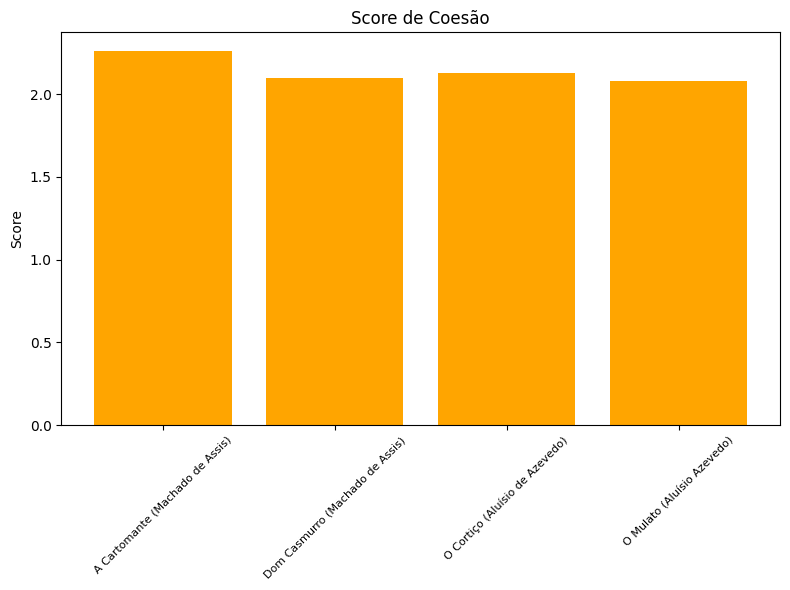

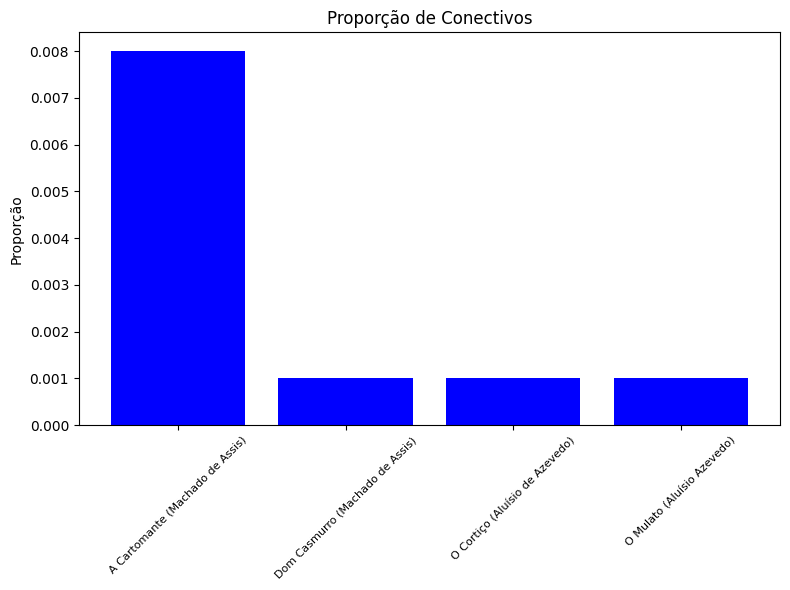

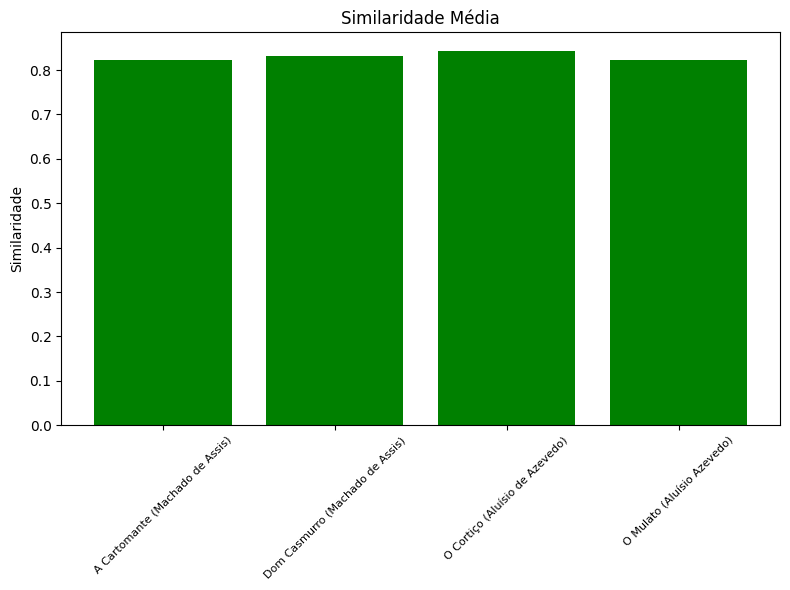

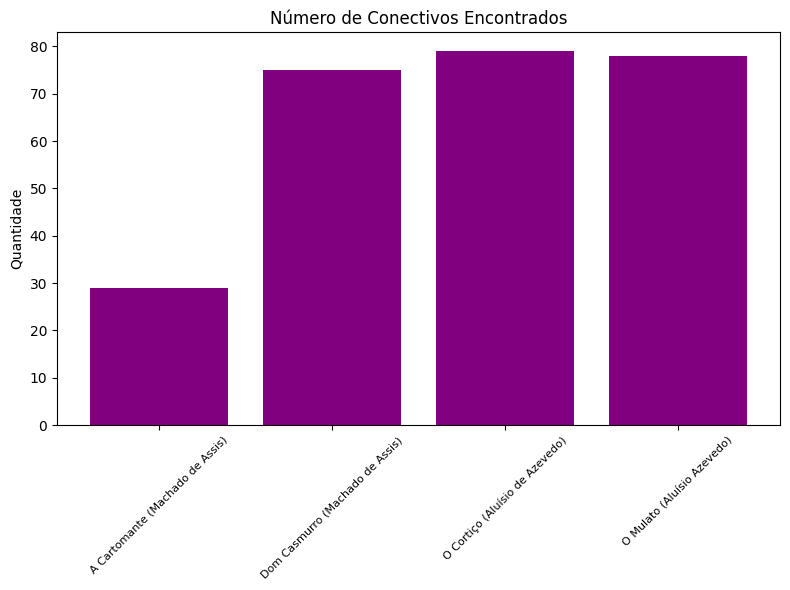

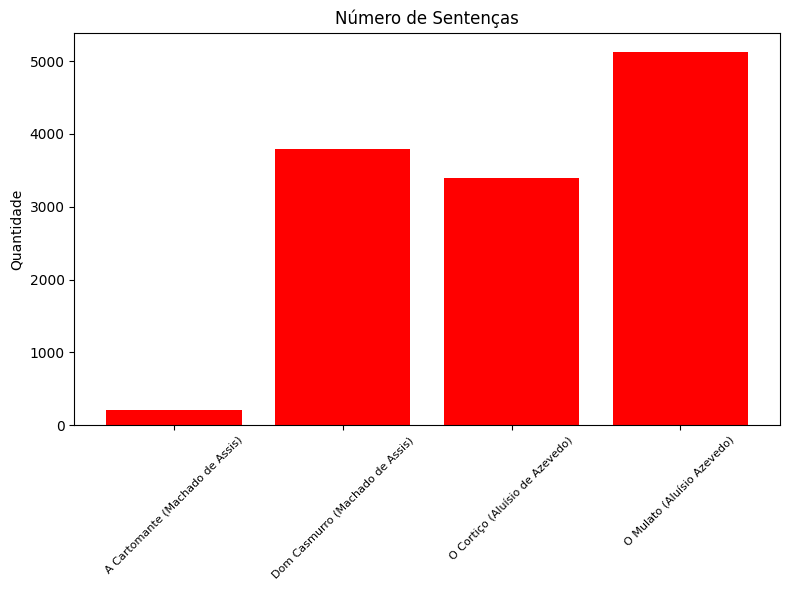

In [14]:
import matplotlib.pyplot as plt

# Dados fornecidos
arquivos = [
    "A Cartomante (Machado de Assis)",
    "Dom Casmurro (Machado de Assis)",
    "O Cortiço (Aluísio de Azevedo)",
    "O Mulato (Aluísio Azevedo)"
]
coesao_scores = [2.26, 2.1, 2.13, 2.08]
proporcoes_conectivos = [0.008, 0.001, 0.001, 0.001]
similaridades_medias = [0.823, 0.831, 0.843, 0.823]
num_conectivos = [29, 75, 79, 78]
num_sentencas = [206, 3789, 3400, 5132]

# Gráfico 1: Score de Coesão
plt.figure(figsize=(8, 6))
plt.bar(arquivos, coesao_scores, color='orange')
plt.title('Score de Coesão')
plt.ylabel('Score')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 2: Proporção de Conectivos
plt.figure(figsize=(8, 6))
plt.bar(arquivos, proporcoes_conectivos, color='blue')
plt.title('Proporção de Conectivos')
plt.ylabel('Proporção')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 3: Similaridade Média
plt.figure(figsize=(8, 6))
plt.bar(arquivos, similaridades_medias, color='green')
plt.title('Similaridade Média')
plt.ylabel('Similaridade')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 4: Número de Conectivos Encontrados
plt.figure(figsize=(8, 6))
plt.bar(arquivos, num_conectivos, color='purple')
plt.title('Número de Conectivos Encontrados')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

# Gráfico 5: Número de Sentenças
plt.figure(figsize=(8, 6))
plt.bar(arquivos, num_sentencas, color='red')
plt.title('Número de Sentenças')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()


### Conclusão
Primeiramente, um fator essencial que notamos é que teremos que tratar a sensibilidade que existe à diferença de tamanho entre os textos, essa é uma questão na qual vamos precisar pensar com cuidado, evitar usar números absolutos será relevante para tornas os parâmetros mais comparáveis. Por fim, nessa próxima etapa nossa intenção é de aumentar a quantidade de features e principalmente o escopo dos dados, utilizar mais autores e textos para nossa análise será essencial mais para frente.